In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/basics`


In [147]:
using ModelingToolkit
using OrdinaryDiffEq, DiffEqCallbacks
using ReferenceFrameRotations, LinearAlgebra
using StaticArrays
using Rotations

using GLMakie
using BenchmarkTools
GLMakie.activate!(inline=true)

Quaternion = ReferenceFrameRotations.Quaternion

ReferenceFrameRotations.Quaternion

In [260]:
function plot_quaternion(sol::ODESolution)
    fig = Figure()
    Axis(fig[1, 1])
    
    lines!(sol.t, sol[q[1]])
    lines!(sol.t, sol[q[2]])
    lines!(sol.t, sol[q[3]])
    lines!(sol.t, sol[q[4]])
    
    display(fig)
end

function plot_quaternion(vec)
    fig = Figure()
    Axis(fig[1, 1])
    
    lines!(sol.t, sol[vq[1]])
    lines!(sol.t, sol[vq[2]])
    lines!(sol.t, sol[vq[3]])
    lines!(sol.t, sol[vq[4]])
    
    display(fig)
end

plot_quaternion (generic function with 2 methods)

## Normalization after each timestep

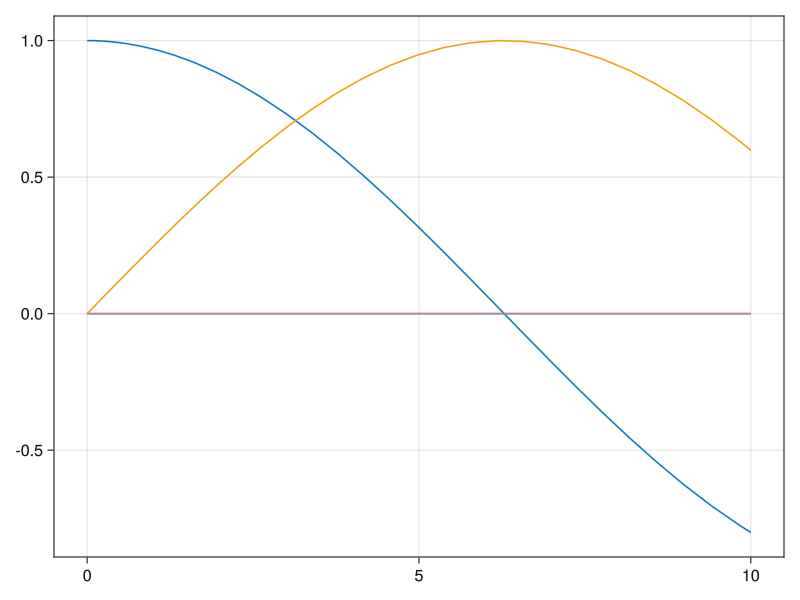

GLMakie.Screen(...)

In [91]:
function vectdquat(vq, ω)
    q = Quaternion(vq)
    dq = dquat(q, ω)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

condition(u, t, integrator) = true

function affect!(integrator)
    integrator.u = integrator.u / norm(integrator.u)
end 

cb = DiscreteCallback(condition, affect!)

@variables t (vq(t))[1:4]
@parameters ω[1:3]
@register vectdquat(vq, ω)
D = Differential(t)

qdot = vectdquat(vq, ω)


eqs = [
    D(vq[1]) .~ qdot[1],
    D(vq[2]) .~ qdot[2],
    D(vq[3]) .~ qdot[3],
    D(vq[4]) .~ qdot[4]
]

@named att_prop = ODESystem(eqs)
tspan = (0.0, 10.0)

prob = ODEProblem(
    att_prop,
    [vq[1] => 1.0, vq[2] => 0.0, vq[3] => 0.0, vq[4] => 0.0],
    tspan,
 [ω[1] => 0.5, ω[2] => 0.0, ω[3] => 0.0]
)

sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, callback = cb)
plot_quaternion(sol)

In [54]:
temp = Vector{Float64}(undef, length(sol.t))

for i in 1:length(sol.t)
    q = sol[vq][i]
    temp[i] = q'*q
end

# plot(sol.t, temp)

## Quaternion exponential

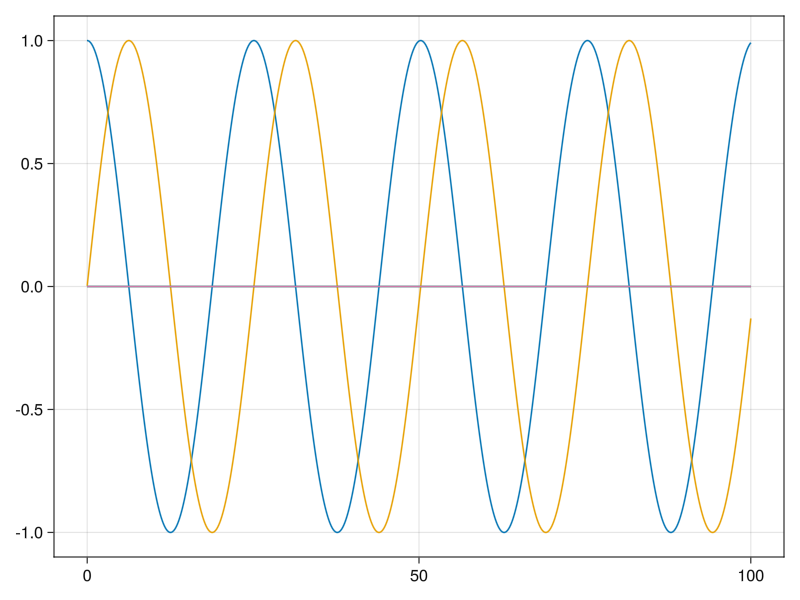

GLMakie.Screen(...)

In [234]:
# to test quaternion exponential function

q = QuatRotation(1,0,0,0)

ω = [0.5 0 0]

tspan = (0,100)
dt = 0.01

q0 = q

t = tspan[1]:dt:tspan[2]
t_vec = collect(t)

q_vec = ones(length(t), 4);

for (i,timestep) in enumerate(t)
    q_exp = exp( QuatRotation(0, ω[1]*dt/2, ω[2]*dt/2, ω[3]*dt/2, false).q);
    q_exp_q = QuatRotation(q_exp.s, q_exp.v1, q_exp.v2, q_exp.v3, false)
    
    q1 = q_exp_q * q0;
    
    q_vec[i,1] = q1.q.s;
    q_vec[i,2] = q1.q.v1;
    q_vec[i,3] = q1.q.v2;
    q_vec[i,4] = q1.q.v3;
    
    q0 = q1;
end

fig = Figure()
Axis(fig[1, 1])

lines!(t_vec, q_vec[:,1])
lines!(t_vec, q_vec[:,2])
lines!(t_vec, q_vec[:,3])
lines!(t_vec, q_vec[:,4])

display(fig)

### Modellingtoolkit implementation

In [330]:
temp = one(QuatRotation)
temp.q[1]

Quaternions.QuaternionF64(1.0, 0.0, 0.0, 0.0)

In [372]:
function digital_controller(int)

    q0_vec = @view int.u[1:4]
    ω = @view int.u[5:7]

    q0 = QuatRotation(q0_vec, false);
    
    dt = 0.01
    
    q_exp = exp( QuatRotation(0, ω[1]*dt/2, ω[2]*dt/2, ω[3]*dt/2, false).q);
    q_exp_q = QuatRotation(q_exp.s, q_exp.v1, q_exp.v2, q_exp.v3, false)
    
    q1 = q_exp_q * q0;
    
    int.u[1:4] = [q1.q.s, q1.q.v1, q1.q.v2, q1.q.v3]

end 

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

@variables t (q(t))[1:4]=0 (ω(t))[1:3]=0

D = Differential(t)

eqn1 = D.(q) .~ 0 
eqn2 = D.(ω) .~ 0 

eqns = vcat(eqn1, eqn2)

@named model = ODESystem(eqns, t)

sys = structural_simplify(model);

  0.004549 seconds (18.06 k allocations: 2.477 MiB)


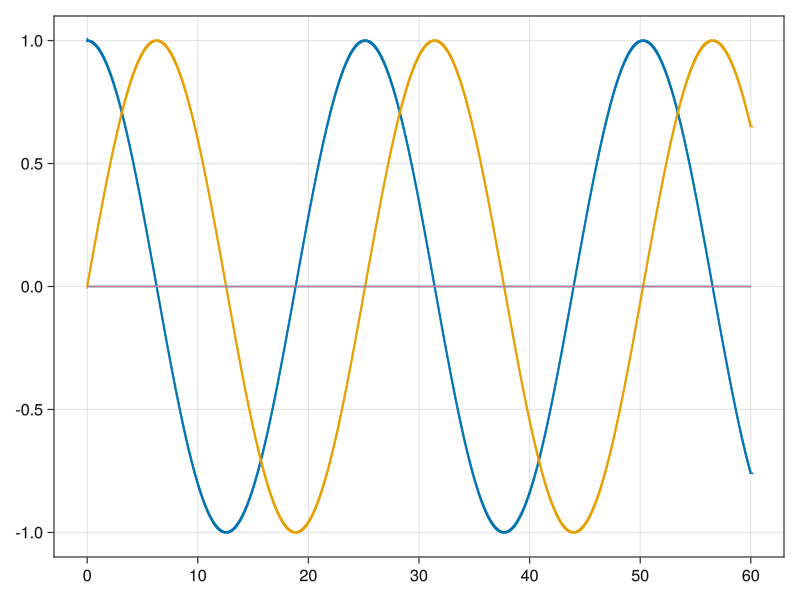

GLMakie.Screen(...)

In [374]:
# sim
tspan = (0.0, 60.0)

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

# initial conditions
ω₀ = [0.5,0.,0.]
q₀ = [1., 0.,0.,0. ]

X₀ = vcat(q₀, ω₀)

prob = ODEProblem(sys, X₀, tspan, callback=control_callback) 
@time sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8 , save_everystep = false);

plot_quaternion(sol)

## Full attitude dynamics 

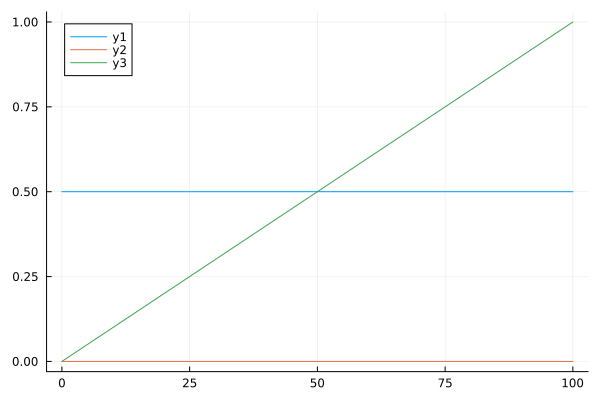

In [72]:
function digital_controller(int)

    q0_vec = @view int.u[1:4]
    ω = @view int.u[5:7]

    q0 = QuatRotation(q0_vec, false);
    
    dt = 0.01
    
    q_exp = exp( QuatRotation(0, ω[1]*dt/2, ω[2]*dt/2, ω[3]*dt/2, false).q);
    q_exp_q = QuatRotation(q_exp.s, q_exp.v1, q_exp.v2, q_exp.v3, false)
    
    q1 = q_exp_q * q0;
    
    int.u[1:4] = [q1.q.s, q1.q.v1, q1.q.v2, q1.q.v3]

end 

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

@variables t (q(t))[1:4]=0 (ω(t))[1:3]=0
@parameters t

D = Differential(t)

eqn1 = D.(q) .~ 0 
eqn2 = D.(ω) .~ 0 

eqns = vcat(eqn1, eqn2)

@named model = ODESystem(eqns, t)

sys = structural_simplify(model);

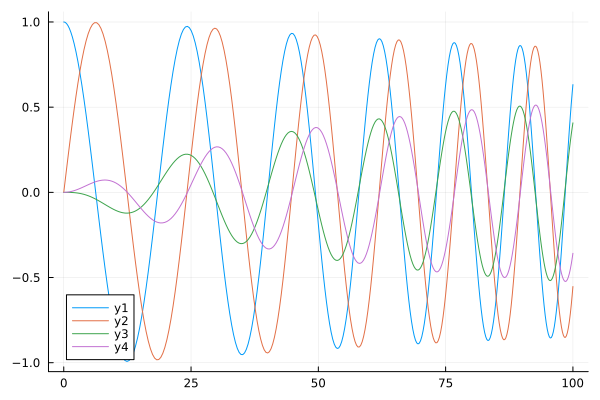

In [68]:
# sim
tspan = (0.0, 60.0)

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

# initial conditions
ω₀ = [0.5,0.,0.]
q₀ = [1., 0.,0.,0. ]

X₀ = vcat(q₀, ω₀)

prob = ODEProblem(sys, X₀, tspan, callback=control_callback) 
@time sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8 , save_everystep = false);

plot_quaternion(sol)